## Find geodesic using neural network and parallel transport

Here we compute the transport map $\mathbf{O}_{ij}:= \mathscr{F}^T_{v \unlhd e}\mathscr{F}_{u \unlhd e}$ according to  https://arxiv.org/pdf/2206.08702.pdf and https://arxiv.org/pdf/1102.0075.pdf

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import torch.nn as nn

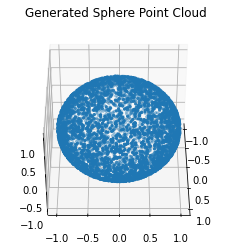

In [2]:
def generate_sphere_point_cloud(num_points, radius=1):
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    theta = np.arccos(2 * np.random.uniform(0, 1, num_points) - 1)

    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)

    return np.column_stack((x, y, z))

#parameters 

n_samples = 5000

# Generate a sphere point cloud with 1000 points and radius 1
sphere_cloud = generate_sphere_point_cloud(n_samples, radius=1)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere_cloud[:, 0], sphere_cloud[:, 1], sphere_cloud[:, 2], s=5)
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(40, 0)
plt.show()

In [3]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:, :dim]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O



In [4]:
## the following is our functions on data cloud   

def log_map_manifold(point_cloud, p, q, stalk_dim = 2, k = 400, epsilon_PCA = 0.1):
    #we first find the basis at point p
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)
    dist_p, p_nbrs_index = nbrs.kneighbors(np.expand_dims(p, axis = 0))
    x_N_p = list_vector_of_index(sphere_cloud, p_nbrs_index)[0][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #then we project the vector q - p to the basis at O_p
    v = q - p
    v_proj = np.dot(v, O_p.T[0]) * O_p.T[0] + np.dot(v, O_p.T[1]) * O_p.T[1]
    return v_proj   
    

def parallel_transport_manifold(point_cloud, v, p, q, stalk_dim = 2, k = 400, epsilon_PCA = 0.1):
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud) 
    #compute basis at p
    dist_p, p_nbrs_index = nbrs.kneighbors(np.expand_dims(p, axis = 0))
    x_N_p = list_vector_of_index(sphere_cloud, p_nbrs_index)[0][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #compute basis at q
    dist_q, q_nbrs_index = nbrs.kneighbors(np.expand_dims(q, axis = 0))
    x_N_q = list_vector_of_index(sphere_cloud, q_nbrs_index)[0][1:]
    X_i_q = x_N_q - q
    D_i_q = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_q[0][1:]) ** 2 / epsilon_PCA)))
    U_q, S_q, VT_q = np.linalg.svd(X_i_q.T @ D_i_q, full_matrices = False)
    O_q = U_q[:, :stalk_dim]
    
    #compute parallel transport
    U, S, VT = np.linalg.svd(O_p.T @ O_q, full_matrices = False)
    O_pq = U @ VT #this is a matrix of 2 x 2
    
    #transport the vector v to at point q
    v_0 = np.array([np.dot(v, O_p.T[0]), np.dot(v, O_p.T[1])])
    v_q = O_pq @ v_0
    v_q = v_q[0] * O_q.T[0] + v_q[1] * O_q.T[1]  #change it to the vector form of coord (x, y, z)
    
    return v_q

def geodesic_distance_manifold(p, q):
    norm = np.linalg.norm(q - p)
    return norm

def exp_map_manifold(point_cloud, p, v, k = 100):
    #p: (n-array) the initial point p in the point cloud   v: (n-array) the dirctional vector 
    #k: number of neighbors used for finding best transported point
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)  
    dist, p_new_index = nbrs.kneighbors(np.expand_dims(p + v, axis = 0))
    q = point_cloud[p_new_index[0][0]]
    
    return q

In [5]:

class MLP(torch.nn.Module):
    def __init__(self, in_dim = 3, out_dim=None, hiden_dim = 64):
        super().__init__()

        if out_dim is None:
            out_dim = in_dim
        self.net = torch.nn.Sequential(
            #torch.nn.Linear(in_dim + (1 if time_varying else 0), hiden_dim),
            torch.nn.Linear(in_dim, hiden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiden_dim, hiden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiden_dim, hiden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hiden_dim, out_dim),
        )
        

    def forward(self, x0, x1):
        #x = torch.linspace(0, 1, steps = slef.N)
        v = self.net((x1 - x0).double())
         
        return v
            
            

In [6]:
Y_0 = torch.from_numpy(sphere_cloud[100])
Y_1 = torch.from_numpy(sphere_cloud[103])

dim = 3
hiden_dim = 16
model = MLP(dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [7]:
Y_0 = torch.tensor([ 0.0851, -0.9299, -0.3579])

In [8]:
Y_1 = torch.tensor([ 0.0851, -0.9299, -0.3579])

In [9]:
# Training loop
num_epochs = 100 

for epoch in range(num_epochs):
    # Forward pass
    V_0 = model(Y_0, Y_1)
    
    # Compute loss
    loss = loss_fn(outputs, B)  
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# After training, you can use the model to perform phase unwinding on new data
new_data = input_data   # Replace with your new data
unwind_data = model(new_data)

RuntimeError: expected scalar type Double but found Float

In [61]:
point_cloud = sphere_cloud
#initialize dimension and number of data points N for interpolation between Y[i]
dim = 3
N = 20

# mean and covariance for noise generation
cov = np.eye(dim)
mean = np.zeros((dim))
noise = np.random.multivariate_normal(mean,cov*0.001,N)



#set the parameters p and v
Y_0 = point_cloud[100]

Y_1 = point_cloud[103]


#define the independent variable x and create array of xiv
x = np.linspace(0, 1, num = N)


In [62]:
#compute gradients
def grad(point_cloud, p, v, y, x, N):
    grad_p = 0
    grad_v = 0
    for i in range(N):
        mapped_value = exp_map_manifold(point_cloud, p, v*x[i])
        error_vec = log_map_manifold(point_cloud, mapped_value, y)
        error_vec_transported = parallel_transport_manifold(point_cloud, error_vec, mapped_value, p) 
        grad_p += error_vec_transported
        grad_v += error_vec_transported * x[i]
        
    return -1*grad_p/N, -1*grad_v/N

def grad_v1(point_cloud, p, v, y, x, N):

    mapped_value = exp_map_manifold(point_cloud, p, v*x)
    error_vec = log_map_manifold(point_cloud, mapped_value, y)
    error_vec_transported = parallel_transport_manifold(point_cloud, error_vec, mapped_value, p) 
    grad_p += error_vec_transported
    grad_v += error_vec_transported * x
        
    return -1*grad_p/N, -1*grad_v/N
  
def compute_cost(X,Y):
    err = 0
    for i in range(N):
        err += geodesic_distance_manifold(X[i],Y[i])
    return err/N
  
#initializing params P and V to a value far from their actual value 
P = point_cloud[100]
V = Y_1 - Y_0


iterations = 500 #number of iterations
lr = 0.1 #learning rate
costs = np.array([])

for i in tqdm(range(iterations)):
    #parameter P update
    grad_pp, grad_vv = grad(point_cloud, Y_0, V, Y_1, x, N)
    #P_new = exp_map_manifold(point_cloud, P, -lr * grad_pp)
    #parameter V update
    V = V - lr * grad_vv
    #V = parallel_transport_manifold(point_cloud, V_new, P, Y_0)

    
    v_array = np.dot(x.reshape(-1,1),V.reshape(1,-1))
    model_output = np.array([exp_map_manifold(point_cloud, P, v_array[i]) for i in range(N)])
    #costs = np.append(costs,compute_cost(Y_1,model_output))

#plt.plot(range(iterations),costs)
#plt.ylabel("Error Function")
#plt.xlabel("Iterations")
#plt.show()

100%|██████████| 500/500 [01:33<00:00,  5.36it/s]


In [63]:
np.linalg.norm(model_output[19])

1.0

In [64]:
def plot_tangent_vector(ax, point, tangent):
    ax.quiver(*point, *tangent, color='r', label='Tangent Vector')


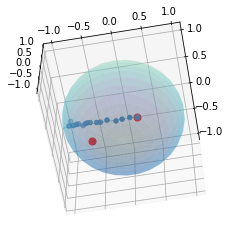

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(model_output[:, 0], model_output[:, 1], model_output[:,2])
ax.scatter(Y_0[0], Y_0[1], Y_0[2], s = 50, c = 'r')
ax.scatter(Y_1[0], Y_1[1], Y_1[2], s = 50, c = 'r')

u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.view_init(-60, 10)
plt.show()

In [245]:
P

array([-0.95270032,  0.28979971,  0.09153269])

In [246]:
p

array([-0.95593459,  0.27488599,  0.10308618])

In [247]:
V

array([0.10021602, 0.30404673, 0.11854198])